In [1]:
# coding: utf-8
from google.colab import files

import os
work_dir = "styleTransfer/"
if os.getcwd() != work_dir:
  !git clone https://github.com/yiyi1026/styleTransfer.git
!git pull

# download result picture
# !tar -cvzf xiaozhen_picasso.tar.gz xiaozhen*
# !tar cvzf - ./xiaozhen_picasso* | split --bytes=20MB - xiaozhen_picasso.tar.gz.
# !ls -lhg
# for char in ['a','b','c','d','e']:
#   name = ('xiaozhen_picasso.tar.gz.a%c' % char)
#   files.download(name)

os.chdir(work_dir)
!pip install --upgrade pip
!pip install --upgrade keras numpy

# In[1]:

import numpy as np
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input
from scipy.optimize import fmin_l_bfgs_b

import argparse
import time


Cloning into 'styleTransfer'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 101.84 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (49/49), done.
fatal: not a git repository (or any of the parent directories): .git
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.4)
    100% |████████████████████████████████| 13.9MB 3.2MB/s 
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


Using TensorFlow backend.


In [0]:

# In[2]:

# default data format is channel_last

def build_parser():
  # arguments preparation
  parser = argparse.ArgumentParser(description="Style Transfer")

  # required arguments
  parser.add_argument('content_img_path', metavar='content', type=str, help='path to content image')
  parser.add_argument('style_img_path', metavar='style', type=str, help='path to style image')
  parser.add_argument('generated_prefix', metavar='gen_prefix', type=str, help='prefix for generated results')

  # optional arguments
  # here?
  parser.add_argument("--content_weight", type=float, default=0.0015, required=False, help="Content Weight")
  parser.add_argument("--style_weight", type=float, default=1.0, required=False, help="Style Weight")
  # parser.add_argument("--tv_weight", type=float, default=1.0, required=False, help="Total Variation Weight")
  parser.add_argument("--iter", type=int, default=50, required=False, help="Number of Iteration")
  return parser

# In[3]:

# # start
# parser = build_parser()

# # fetch arguments
# args = parser.parse_args()

# fetch required arguments
# content_img_path = args.content_img_path
# style_img_path = args.style_img_path
# generated_prefix = args.generated_prefix

## test for jupyter implementation
content_img_path = 'images/003sydney.jpg'
style_img_path = 'images/style_picasso.jpg'
generated_prefix = 'xiaozhen_picasso'

# # fetch optional arguments
# content_weight = args.content_weight
# style_weight = args.style_weight
# iteration = args.iter
# tv_weight = args.tv_weight

## test for jupyter implementation
content_weight = 0.00125
style_weight = 1.0
tv_weight = 1.0
iteration = 100

width, height = load_img(content_img_path).size
# print([width,height])
img_height = 500
img_width = int(width * img_height / height)

# In[4]:

def preprocess_img(img_path):
    
  # load image as JpegImageFile
  img = load_img(img_path, target_size = (img_height, img_width))

  # convert JpegImageFile into ndarray(a multidimensional, fixed size array object)
  img = img_to_array(img)

  # reshape 3-dimension img into 4-dimension img (by add a dimension upfront)
  img = np.expand_dims(img, axis=0)

  # preprocess image so as to be compatible for keras
  np_img = preprocess_input(img)

  return np_img

def deprocess_img(np_img):
  # print("deprocess_img")
  # print(K.image_data_format())
  np_img = np_img.reshape((img_height, img_width, 3))

  # add back testing-mean-pixel (due to default manipulation in openCV from Caffe of Keras)
  np_img[:, :, 0] += 103.939
  np_img[:, :, 1] += 116.779
  np_img[:, :, 2] += 123.68

  # BGR to RGB(due to default manipulation in openCV from Caffe of Keras)
  np_img = np_img[:, :, ::-1]
  img = np.clip(np_img, 0, 255).astype('uint8')
  return img

# In[5]:

# get tensor representations of input images and ouput images in (samples, height, width, channels) shape (1, height, width, channel)
content_img = K.variable(preprocess_img(content_img_path))
style_img = K.variable(preprocess_img(style_img_path))
#### test confirms above

# initial noise image
noise_img = np.random.randint(256, size=(1, img_height, img_width, 3)).astype('float64')
# change???

# save_img('noise_img.png', deprocess_img(noise_img))
generated_img = K.placeholder((1, img_height, img_width, 3))
# generated_img = K.variable(noise_img)

# In[6]:

# 4 util loss functions
def content_loss(original, generated):
  cl = (K.sum(K.square(original - generated)))
  return cl

# help method for computing style loss
def gram_matrix(input):
  # n-dimensions to 2 dimensions
  temp = K.permute_dimensions(input, (2, 0, 1))
  features = K.batch_flatten(temp)
 
  # if features is n*m, return n*n
  matrix = K.dot(features, K.transpose(features))
  return matrix

def style_loss(style, generated):
  style_gram = gram_matrix(style)
  gen_gram = gram_matrix(generated)
  nl = 3
  nl_size = img_height * img_width
  sl = K.sum(K.square(style_gram-gen_gram))/(4. * (nl ** 2) * (nl_size ** 2))
  return sl

# In[7]:

# generate tensor for 3 images
input_tensor = K.concatenate([content_img, style_img, generated_img], axis=0)
# initialize the VGG19 model
model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
print("VGG19 Model loaded")
# store layer.name and layer.output in dictionary
layer_outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
style_features_names = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

# combine the above several loss functions together
def total_loss():
  loss = K.variable(0.)
  # content_loss
  content_layer_name = 'block5_conv2'
  content_layer_features = layer_outputs_dict[content_layer_name]
  content_features = content_layer_features[0,:,:,:]
  generated_features = content_layer_features[2,:,:,:]
  loss = loss + content_weight * content_loss(content_features, generated_features)

  # style_loss
  active_layers_count = len(style_features_names)
  for layer_name in style_features_names:
    style_layer_features = layer_outputs_dict[layer_name]
    style_features = style_layer_features[1,:,:,:]
    generated_features = style_layer_features[2,:,:,:]
    style_loss_of_this_layer = style_loss(style_features, generated_features)
    loss = loss + (style_weight / active_layers_count) * style_loss_of_this_layer

  return loss


# In[12]:


l = total_loss()

# reference https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py

# should this line be outside the generated_grad_func or inside?
#grads = K.gradient(l, generated_img)

# generate data point =>loss function
def generated_grad_func(l, generated_img):
  grads = K.gradients(l, generated_img)
  outputs = [l]
  if isinstance(grads, (list, tuple)):
    outputs += grads
  else:
    outputs.append(grads)

  f_outputs = K.function([generated_img], outputs)
  return f_outputs

f_outputs = generated_grad_func(l, generated_img)

def eval_loss_and_grads(x):
    x = x.reshape((1, img_height, img_width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

  def __init__(self):
    self.loss_value = None
    self.grads_value = None

  def loss(self, x):
    assert self.loss_value is None
    loss_value, grad_value = eval_loss_and_grads(x)
    self.loss_value = loss_value
    self.grads_value = grad_value
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grads_values = np.copy(self.grads_value)
    self.loss_value = None
    self.grads_value = None
    return grads_values

# In[13]:

def main():
  evaluator = Evaluator()
  input = preprocess_img(content_img_path)
  for i in range(iteration):
    print('Iteration %d Start' % i)
    start_time = time.time()
    input, min_val, info = fmin_l_bfgs_b(evaluator.loss, input.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss', min_val)
    current_img = deprocess_img(input.copy())
    processing_name = generated_prefix + '_at_iteration_%d.png' % i
    save_img(processing_name, current_img)
    end_time = time.time()
    print('interation %d completed in %ds' % (i, end_time-start_time))
  return(i)
main()

80142336/80134624 [==============================] - 3s 0us/step
VGG19 Model loaded
Iteration 0 Start
Current loss 1869392300.0
interation 0 completed in 37s
Iteration 1 Start
Current loss 901903400.0
interation 1 completed in 27s
Iteration 2 Start
Current loss 656791200.0
interation 2 completed in 27s
Iteration 3 Start
Current loss 499552200.0
interation 3 completed in 29s
Iteration 4 Start
Current loss 413670200.0
interation 4 completed in 27s
Iteration 5 Start
Current loss 356558200.0
interation 5 completed in 27s
Iteration 6 Start
Current loss 319586020.0
interation 6 completed in 27s
Iteration 7 Start
Current loss 286820960.0
interation 7 completed in 27s
Iteration 8 Start
Current loss 259295820.0
interation 8 completed in 27s
Iteration 9 Start


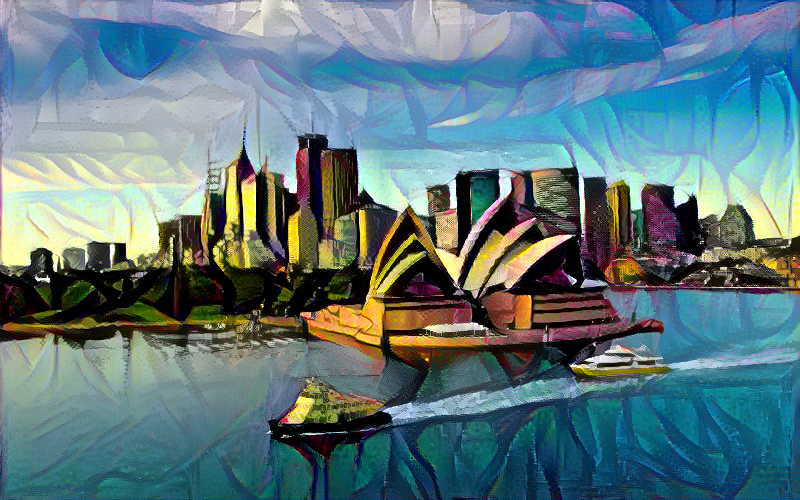

In [0]:
# !ls
from IPython.display import Image
Image('xiaozhen_picasso_at_iteration_9.png')
# Image('xiaozhen_picasso_at_iteration_19.png')
# Image('xiaozhen_picasso_at_iteration_29.png')
# Image('xiaozhen_picasso_at_iteration_39.png')
# Image('xiaozhen_picasso_at_iteration_49.png')
# Image('xiaozhen_picasso_at_iteration_59.png')
# Image('xiaozhen_picasso_at_iteration_69.png')
# Image('xiaozhen_picasso_at_iteration_79.png')
# Image('xiaozhen_picasso_at_iteration_89.png')
# Image('xiaozhen_picasso_at_iteration_99.png')